## Implementação de classificação de imagens

**Classificação de Imagens**

> Neste módulo é possível acompanhar a implementação de um processo de classificação de imagens utilizando técnicas clássicas de Processamento Digital de Imagens e treinar classificadores para predição dos atributos.

In [1]:
### Módulos necessários
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics,svm
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from sklearn.preprocessing import MaxAbsScaler

- **O Problema**
> Suponha que seja necessário identificação automática de uma figura geométrica por análise de imagens. As figuras que precisam ser identificadas estão definidas na Figura abaixo.

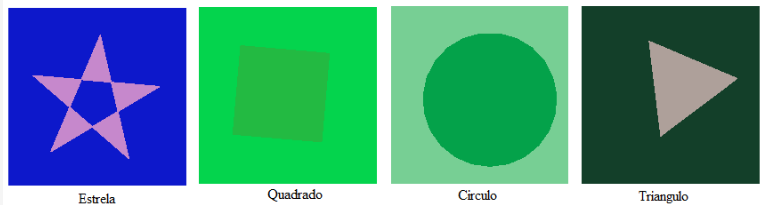

> Neste contexto, de forma automática, uma aplicação deve ser implementada de maneira que esta receba uma imagem e retorne o tipo de figura geométrica contida, com base no padrão definido neste dataset.


- **Preparando o dataset**

> Neste primeiro momento há necessidade de observar as imagens do dataset e organizá-las em uma estrutura de dados adequada para que seus atributos possam ser extraídos. há então a necessidade de carregar o conjunto de imagens via código. Abaixo segue um exemplo de uma função para carregar o conjunto de imagens e retornar estas estruturadas em lista e outra lista indicando classe de cada imagem.

In [2]:
def load_data(datadir, classes, img_size=100):
    training_data = []
    label = []
    for classe in range(len(classes)):
        path = os.path.join(datadir, classes[classe])
        shufled_list  = list(os.listdir(path))
        shuffle(shufled_list)
        for img in shufled_list:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array, (img_size, img_size))
            unique = np.unique(img_array)
            if len(unique) == 1:
                continue
            training_data.append(img_array)
            label.append(classe)
    return training_data , label

In [3]:
data , label = load_data('dataset/geometric',['circle','square','star','triangle'])

- O código acima realiza a implementação de uma função que recebe 3 argumentos: o diretório que contem as pastas das imagens, uma lista de string que contém o nome das classes que devem ser reconhecidas e um parâmetro default que é o  tamanho da imagem que será utilizado em todo o processo. 

- São definidas duas listas vazias training_data e label. Em training_data serão armazenadas as imagens e em label serão definidos números que representam cada classe.Deste modo, é possível saber a classe da imagem que estiver na posição 5 da lista training_data observando o número contido da quinta posição da lista label.

- Um loop for é realizado para iterar sobre as possíveis classes. Assim a variável classe,definida no loop, poderá assumir valores variando de  0 até 3, em que 0 representa classe 'circle' e 3 representa a classe 'triangle'. Na variável path é armazenada a string que contem o caminho para pasta de imagens da classe específica, conforme iteração do loop for e na estrutura shufled_list são contidas strings que são os caminhos de cada imagem da classe, já com um primeiro embaralhamento.
O segundo loop for itera sobre os caminhos das imagens específicas e armazena estas em tom de cinza na variável img_array. A imagem é redimensionada, armazenada na lista training_data e variável classe é armazenada na lista label. Foi observado inconsistências neste dataset específico, em que há casos de imagens com um único tom de cinza. Estas são descartadas através da verificação junto a função unique da numpy auxiliada pelo comando if.

- **Extração de atributos**
> De posse das imagens estruturadas, agora vamos extrair informações destas imagens para que estes dados sirvam de atributos. Neste caso a função features_extraction é responsável por isso.

In [4]:
def get_contours_param(contour):
    contour_area = contour[0].filled_area
    contour_perimeter = contour[0].perimeter
    contour_convex_area = contour[0].convex_area
    diameter = contour[0].equivalent_diameter
    return contour_area , contour_perimeter, contour_convex_area, diameter

In [5]:
def features_extraction(images):
    features_list = []
    for image in images:
        thresh = threshold_otsu(image)
        binary = np.array(image > thresh).astype(int)
        white_pixel = np.where(binary > 0)
        if len(white_pixel[0]) > 7000:
            binary = abs(1-binary) # ajuste de imagens negativas
        regions = regionprops(binary)
        contour_area , contour_perimeter, contour_convex_area, diameter = get_contours_param(regions)
        features_list.append([contour_area , contour_perimeter, contour_convex_area, diameter])
    norm =  MaxAbsScaler()
    norm.fit(features_list)
    norm_features = norm.transform(features_list)
    return norm_features

features = features_extraction(data)

- Nesta etapa, features_extraction recebe a lista de imagens que foi obtida em load_data. Nesta função é aplicada a limiarização de Otsu de forma iterativa com auxílio do loop for. Neste caso de imagens sintéticas, existe a possibilidade de o processo de limiarização de Otsu gerar imagens binarizadas, mas algumas sendo negativas. Assim é realizado a contagem de pixels brancos para garatir que estes componham o objeto e não o plano de fundo. Essa análise é específica para este dataset em particular. Essa lógica está implementada na analíse de white_pixels. Por isso, quando são contabilizados mais que 7000 pixels brancos, sugere-se que há caso de limiarização negativa.


- O Método regionprops é utilizado para segmentar as regiões geométricas da imagem. Contexto, a função get_contours_param é implementada para extrair os atributos do contorno. Ative o modo DEBUG da sua IDE para poder observar outros atributos que podem ser extraídos.


- Por fim, é realizada a normalização dos atributos para dimensionar cada atributo individualmente de modo que o valor absoluto máximo de cada um no conjunto de treinamento seja 1,0. A função MaxAbsScaler realiza isso.

- **Treinamento e Teste dos Classificadores.**
> A variável features possui as os atributos extraídos das imagens. Neste contexto, a função gen_classifiers é iamplementada para retornar testes em 7 classificadores: Random Forest, MLP, KNN, SGDC, SVM, Árvore de decisão e Naive Bayes.

In [6]:
def generate_svm_model(train_data,label_train_data,test_data):
    clf = svm.SVC(kernel='linear')
    clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_SGDC_model(train_data,label_train_data,test_data):
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)
    clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_naive_bayes_model(train_data,label_train_data,test_data):
    gnb = GaussianNB()
    gnb.fit(train_data, label_train_data)
    predicted = gnb.predict(test_data)
    return predicted
def generate_decision_tree_model(train_data,label_train_data,test_data):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(train_data, label_train_data)
    predicted = clf.predict(test_data)
    return predicted
def generate_random_forest_model(X_train, y_train,test_data):
    rfc = RandomForestClassifier(criterion= 'entropy', max_depth= 8, max_features='auto', n_estimators=200)
    rfc.fit(X_train,y_train)
    predicted = rfc.predict(test_data)
    return predicted
def generate_MLP_model(X_train, y_train,test_data):
    classifier = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=300,activation = 'relu',solver='adam',random_state=1)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(test_data)
    return predicted
def generate_knn_model(train_data,label_train_data,test_data):
    knn = KNeighborsClassifier()
    knn.fit(train_data,label_train_data)
    predicted = knn.predict(test_data)
    return predicted

In [7]:
def gen_classifiers(train_data,label_train_data,test_data):
    return generate_knn_model(train_data,label_train_data,test_data),\
    generate_MLP_model(train_data,label_train_data,test_data),\
    generate_SGDC_model(train_data,label_train_data,test_data),\
    generate_svm_model(train_data,label_train_data,test_data),\
    generate_decision_tree_model(train_data,label_train_data,test_data),\
    generate_naive_bayes_model(train_data,label_train_data,test_data),\
    generate_random_forest_model(train_data,label_train_data,test_data),

In [8]:
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.3)
results = gen_classifiers(X_train, y_train,X_test)

- A função divide o conjunto de atributos e labels em conjuntos de treino e teste para garantirmos que o processo de treinamento seja realizado com dados distintos dos que vão ser testados por cada classificador.

- Deste modo, a função gen_classifiers recebe os atributos de treinamento, as labels dos atributos de treinamento e os atribiutos de teste e retorna um array de valores que indicam os resultados dos testes de cada classificador. Cada classificador é inicializado com um objeto específico. Após a inicialização é realizado o comando fit para treinar o classificadorque recebe os atribiutos de treinamento e as labels dos atributos. Após o treinamento é realizado o comando predict para testar se o classificador realiza uma predição correta de atributos que não foram utilizados no conjunto de treinamento. A variável predicted é um vetor em que cada elemento do vetor é um valor que indica a classe a qual o atributo pertence. 

- **Avaliação dos classificadores**
> A biblioteca sklearn possui funções que auxiliam a medir quantitativamente o desempenho do classificador. A acurácia do classificador pode ser medida pela chamada da função seguinte:

In [9]:
acc_knn = metrics.accuracy_score(y_test, results[0])
acc_MLP = metrics.accuracy_score(y_test, results[1])
acc_SGDC = metrics.accuracy_score(y_test, results[2])
acc_svm = metrics.accuracy_score(y_test, results[3])
acc_decision_tree = metrics.accuracy_score(y_test, results[4])
acc_naive_bayes = metrics.accuracy_score(y_test, results[5])
acc_random_forest = metrics.accuracy_score(y_test, results[6])

print("Acc KNN: {}".format(acc_knn))
print("Acc MLP: {}".format(acc_MLP))
print("Acc SGDC: {}".format(acc_SGDC))
print("Acc svm: {}".format(acc_svm))
print("Acc decision_tree: {}".format(acc_decision_tree))
print("Acc naive_bayes: {}".format(acc_naive_bayes))
print("Acc random_forest: {}".format(acc_random_forest))

Acc KNN: 0.9817518248175182
Acc MLP: 0.9981751824817519
Acc SGDC: 0.6386861313868614
Acc svm: 0.6459854014598541
Acc decision_tree: 0.9470802919708029
Acc naive_bayes: 0.5218978102189781
Acc random_forest: 0.9452554744525548


VP = Verdadeiro positivo - objeto pertence a classe A e foi classificado na classe A

VN = Verdadeiro negativo - objeto não pertence a classe A e não foi classificado na classe A

FP = Falso positivo - objeto não pertence a classe A e foi classificado na classe A

FN = Falso negativo - objeto pertence a classe A e não foi classificado na classe A

A sensibilidade/revocação/recall do classificador, por classe,  pode ser medida pela chamada da função seguinte:

In [18]:
def recall(y_test, results):
    return metrics.recall_score(y_test, results, average=None)

print("recall KNN: {}".format(recall(y_test, results[0])))
print("recall MLP: {}".format(recall(y_test, results[1])))
print("recall SGDC: {}".format(recall(y_test, results[2])))
print("recall svm: {}".format(recall(y_test, results[3])))
print("recall decision_tree: {}".format(recall(y_test, results[4])))
print("recall naive_bayes: {}".format(recall(y_test, results[5])))
print("recall random_forest: {}".format(recall(y_test, results[6])))

recall KNN: [0.95238095 0.95652174 1.         1.        ]
recall MLP: [1.         0.98913043 1.         1.        ]
recall SGDC: [0.96825397 0.         1.         0.41714286]
recall svm: [0.44444444 0.         0.79354839 1.        ]
recall decision_tree: [0.95238095 0.88043478 0.97419355 0.95428571]
recall naive_bayes: [0.23015873 0.30434783 0.49677419 0.86857143]
recall random_forest: [0.91269841 0.79347826 1.         1.        ]


In [28]:
modelo = ["KNN", "MLP", "SGDC", "svm", "decision_tree", "naive_bayes", "random_forest"]

def precision(y_test, results):
    return metrics.precision_score(y_test, results, average=None)

def recall(y_test, results):
    return metrics.recall_score(y_test, results, average=None)

def f1_score(y_test, results):
    return metrics.f1_score(y_test, results, average=None)

def printScore(modelo, avali):
    for i in range(0, len(modelo)):
        print("precision {}: {}".format(modelo[i], avali(y_test, results[i])))

print("Precision")
printScore(modelo, precision)

print("recall")
printScore(modelo, recall)

print("f1_score")
printScore(modelo, f1_score)


Precision
precision KNN: [0.96774194 0.93617021 1.         1.        ]
precision MLP: [0.99212598 1.         1.         1.        ]
precision SGDC: [0.65240642 0.         0.68584071 0.76041667]
precision svm: [0.76712329 0.         1.         0.49715909]
precision decision_tree: [0.9375     0.9        0.96794872 0.95977011]
precision naive_bayes: [0.64444444 0.35       1.         0.43930636]
precision random_forest: [0.97457627 0.92405063 1.         0.89285714]
recall
precision KNN: [0.95238095 0.95652174 1.         1.        ]
precision MLP: [1.         0.98913043 1.         1.        ]
precision SGDC: [0.96825397 0.         1.         0.41714286]
precision svm: [0.44444444 0.         0.79354839 1.        ]
precision decision_tree: [0.95238095 0.88043478 0.97419355 0.95428571]
precision naive_bayes: [0.23015873 0.30434783 0.49677419 0.86857143]
precision random_forest: [0.91269841 0.79347826 1.         1.        ]
f1_score
precision KNN: [0.96       0.94623656 1.         1.        ]
p

C:\Users\andressa.moreira\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
f1_score =  metrics.f1_score(y_test,results[0],average=None)
print(f1_score)

[0.96       0.94623656 1.         1.        ]
